# IDB_drilling_signal2

## Import packages

In [1]:
import IPython
import librosa
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import scipy.io as scio
import seaborn as sns
import time
# import visualkeras

from keras.layers import Activation, BatchNormalization, Concatenate, Conv1D, Conv2D, Dense, Dropout, Flatten, GlobalAveragePooling1D, GlobalAveragePooling2D, Input, MaxPooling1D, MaxPooling2D
from keras.models import load_model, Model, Sequential
from keras.utils.np_utils import to_categorical
# from pyts.image import RecurrencePlot, MarkovTransitionField, GramianAngularField
from tensorflow import keras
from tqdm import tqdm

# import xgboost as xgb
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

!nvidia-smi

HOST_path = "/root/autodl-tmp"

random.seed(42)

def nameof(var):
    for name, value in globals().items():
        if value is var:
            return name

2023-10-25 20:57:33.407798: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Wed Oct 25 20:57:35 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:17:00.0 Off |                  Off |
| 30%   27C    P8    19W / 450W |  23596MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load signal data

In [2]:
def read_allFile(signal_path):
    signal_value, signal_rate = librosa.load(signal_path, sr=None, mono=True, offset=0.0, duration=None)
    SEC = len(signal_value)/signal_rate
    hour = int(SEC // 3600)
    minute = int((SEC - hour*3600) // 60)
    second = int(SEC - hour*3600 - minute*60)
    print("signal_shape:", signal_value.shape, "sampling_rate:", signal_rate, "time:",
          len(signal_value)/signal_rate, "seconds: ", hour, "h", minute, "m", second, "s")
    return signal_value

B8281 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal2/Rock_drilling_signal/B8-28-1.WAV"))
B8282 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal2/Rock_drilling_signal/B8-28-2.WAV"))
B8283 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal2/Rock_drilling_signal/B8-28-3.WAV"))

B8341 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal2/Rock_drilling_signal/B8-34-1.WAV"))
B8342 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal2/Rock_drilling_signal/B8-34-2.WAV"))
B8343 = read_allFile(os.path.join(HOST_path, "IDB_drilling_signal2/Rock_drilling_signal/B8-34-3.WAV"))

RATE = 96000

signal_shape: (355621888,) sampling_rate: 96000 time: 3704.3946666666666 seconds:  1 h 1 m 44 s
signal_shape: (536855552,) sampling_rate: 96000 time: 5592.245333333333 seconds:  1 h 33 m 12 s
signal_shape: (519438336,) sampling_rate: 96000 time: 5410.816 seconds:  1 h 30 m 10 s
signal_shape: (511225856,) sampling_rate: 96000 time: 5325.269333333334 seconds:  1 h 28 m 45 s
signal_shape: (536854528,) sampling_rate: 96000 time: 5592.234666666666 seconds:  1 h 33 m 12 s
signal_shape: (463131648,) sampling_rate: 96000 time: 4824.288 seconds:  1 h 20 m 24 s


## Plot signal data

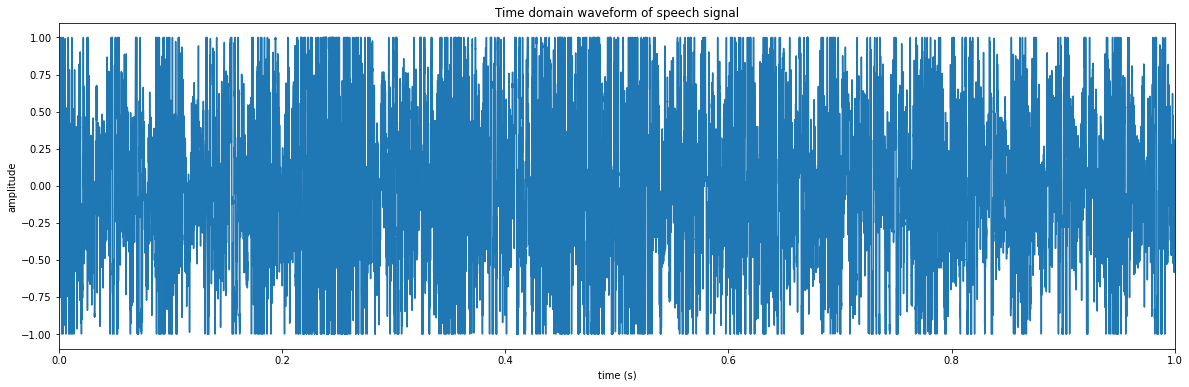

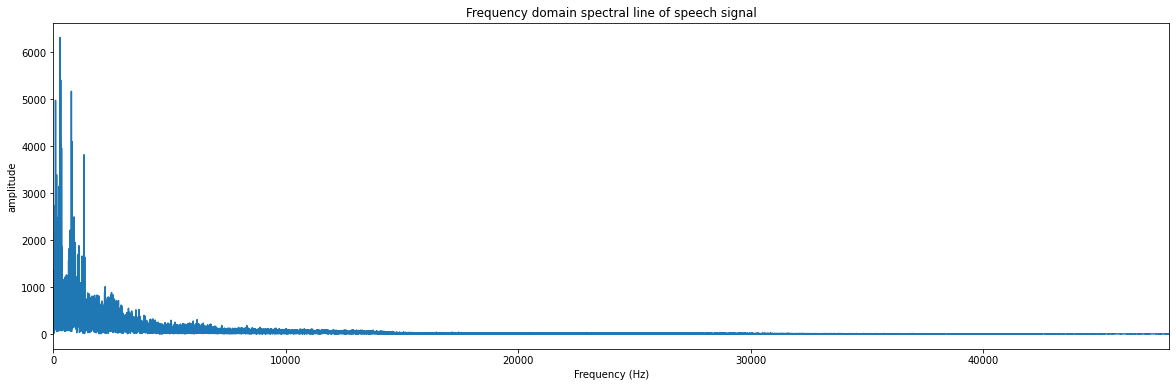

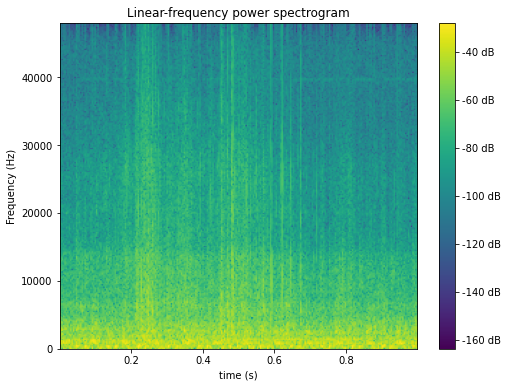

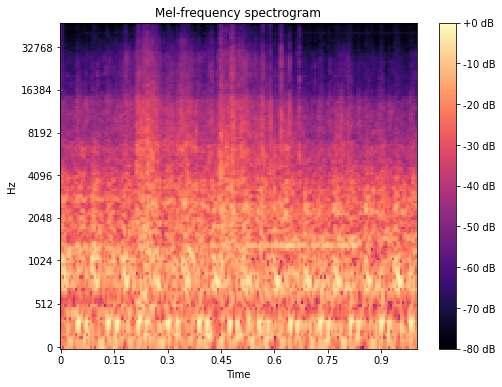

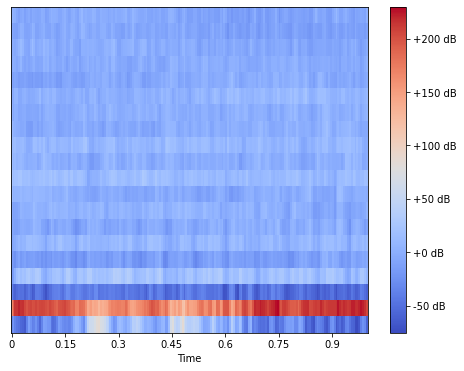

In [3]:
def displayWaveform(signal, rate):
  plt.figure(figsize=(20,6))
  max = np.max(np.absolute(signal))*1.2
  time = np.arange(0, len(SIGNAL)) / RATE
  plt.plot(time, signal)
  plt.title("Time domain waveform of speech signal")
  plt.xlabel("time (s)")
  plt.ylabel("amplitude")
  plt.xlim(0,len(SIGNAL)/RATE)
  ymin, ymax = plt.ylim()
  ylim = np.maximum(np.abs(ymin), np.abs(ymax))
  plt.ylim(-ylim, ylim)

def displaySpectrum(signal, rate):
  plt.figure(figsize=(20,6))
  s = np.fft.fft(signal)
  m = np.abs(s)
  n = len(signal)
  f = np.fft.fftfreq(n, 1/rate)
  plt.plot(f[:n//2],m[:n//2])
  plt.title("Frequency domain spectral line of speech signal")
  plt.xlabel("Frequency (Hz)")
  plt.ylabel("amplitude")
  plt.xlim(0, rate//2)

def displaySpectrogram(signal, rate, fftlen):
  plt.figure(figsize=(8,6))
  plt.specgram(signal, NFFT=fftlen, Fs=rate, noverlap=int(fftlen*0.25), window=np.hanning(fftlen))
  plt.title('Linear-frequency power spectrogram')
  plt.xlabel('time (s)')
  plt.ylabel('Frequency (Hz)')
  plt.colorbar(format="%+2.0f dB")

def displayMelspectrogram(signal, rate):
  plt.figure(figsize=(8,6))
  # melspectrogram = librosa.feature.melspectrogram(y=signal, sr=rate)
  D = np.abs(librosa.stft(signal))**2
  S = librosa.feature.melspectrogram(S=D, sr=rate)
  S_dB = librosa.power_to_db(S, ref=np.max)
  img = librosa.display.specshow(S_dB, sr=rate, fmax=rate/2, x_axis='time', y_axis='mel')
  plt.title('Mel-frequency spectrogram')
  plt.colorbar(format='%+2.0f dB')

def diaplayMFCC(signal, rate):
  plt.figure(figsize=(8,6))
  mfccs = librosa.feature.mfcc(y=signal, sr=rate)
  librosa.display.specshow(mfccs, sr=rate, x_axis='time')
  plt.colorbar(format='%+2.0f dB')

def plot_wave(signal, rate):
  displayWaveform(signal, rate)
  displaySpectrum(signal, rate)
  displaySpectrogram(signal, rate, fftlen=512)
  displayMelspectrogram(signal, rate)
  diaplayMFCC(signal, rate)

SIGNAL = B8281[0:RATE]
plot_wave(SIGNAL, RATE)
IPython.display.Audio(data=SIGNAL, rate=RATE)

## Cut signal data

In [4]:
MIN = 60*RATE

# B828_0003_KK = B8281[0*MIN:11*MIN]
# B828_0003_XG = B8281[14*MIN:17*MIN]
# B828_0003_XZ = B8281[17*MIN:18*MIN]
B828_0306_ZJ = B8281[18*MIN:21*MIN]
B828_0306_ZJ2 = B8281[24*MIN:35*MIN]
# B828_0306_TZ = B8281[35*MIN:36*MIN]
# B828_0306_QX = B8281[36*MIN:37*MIN]
# B828_0306_XZ = B8281[37*MIN:38*MIN]
B828_0609_ZJ = B8281[38*MIN:47*MIN]
# B828_0609_TZ = B8281[48*MIN:51*MIN]
# B828_0609_QX = B8281[52*MIN:56*MIN]
# B828_0609_XZ = B8281[56*MIN:58*MIN]
B828_0912_ZJ = B8281[58*MIN:59*MIN]

B828_0912_ZJ2 = B8282[2*MIN:13*MIN]
# B828_0912_TZF = B8282[16*MIN:25*MIN]
# B828_0912_QX = B8282[25*MIN:26*MIN]
# B828_0912_XZ = B8282[26*MIN:27*MIN]
B828_1217_ZJ = B8282[27*MIN:48*MIN]
# B828_1217_QX = B8282[2*MIN:13*MIN]
# B828_1217_XZ = B8282[49*MIN:52*MIN]
B828_1720_ZJ = B8282[53*MIN:63*MIN]
# B828_1720_TZ = B8282[63*MIN:63*MIN]
# B828_1720_QX = B8282[63*MIN:63*MIN]
# B828_1720_XZ = B8282[63*MIN:63*MIN]
B828_2023_ZJ = B8282[64*MIN:]
# B828_2023_TZ = B8283[0*MIN:5*MIN]
# B828_2023_QXF = B8283[5*MIN:12*MIN]
# B828_2023_XZ = B8283[13*MIN:16*MIN]
B828_2326_ZJ = B8283[16*MIN:83*MIN]

# B834_0003_KK = B8341[1*MIN:12*MIN]
# B834_0003_XG = B8341[14*MIN:25*MIN]
# B834_0003_XZ = B8341[26*MIN:27*MIN]
B834_0003_ZJ = B8341[28*MIN:30*MIN]
# B834_0003_TZ = B8341[31*MIN:32*MIN]
# B834_0003_QX = B8341[32*MIN:33*MIN]
# B834_0003_XZ2 = B8341[33*MIN:34*MIN]
B834_0306_ZJ = B8341[35*MIN:39*MIN]
# B834_0306_TZ = B8341[39*MIN:43*MIN]
# B834_0306_QX = B8341[44*MIN:int(44.5*MIN)]
# B834_0306_XZ = B8341[int(44.5*MIN):45*MIN]
B834_0609_ZJ = B8341[46*MIN:57*MIN]
# B834_0609_TZ = B8341[57*MIN:58*MIN]
# B834_0609_QX = B8341[58*MIN:int(58.4*MIN)]
# B834_0609_XZ = B8341[int(58.4*MIN):int(58.8*MIN)]
B834_0912_ZJ = B8341[int(58.8*MIN):73*MIN]
# B834_0912_TZ = B8341[74*MIN:78*MIN]
# B834_0912_QX = B8341[78*MIN:79*MIN]
# B834_0912_XZ = B8341[79*MIN:82*MIN]
B834_1215_ZJ = B8341[82*MIN:86*MIN]

# B834_1215_TZ = B8342[0*MIN:0*MIN]
# B834_1215_QX = B8342[0*MIN:4*MIN]
# B834_1215_XZ = B8342[0*MIN:7*MIN]
B834_1518_ZJ = B8342[7*MIN:40*MIN]
# B834_1518_TZ = B8342[41*MIN:43*MIN]
# B834_1518_QX = B8342[43*MIN:44*MIN]
# B834_1518_XZ = B8342[44*MIN:47*MIN]
B834_1823_ZJ = np.append(B8342[47*MIN:],B8343[0*MIN:15*MIN])
# B834_1823_TZ = B8343[15*MIN:18*MIN]
# B834_1823_QX = B8343[18*MIN:19*MIN]
# B834_1823_XZ = B8343[20*MIN:22*MIN]
B834_2326_ZJ = B8343[22*MIN:70*MIN]
# B834_2326_TZ = B8343[70*MIN:75*MIN]
# B834_2326_QX = B8343[75*MIN:77*MIN]
# B834_2326_TG = B8343[77*MIN:77*MIN]

## Pick signal data

In [5]:
def pick_signal(signals):
  sample_size = int(RATE/2)
  sample_step = int(sample_size/2)
  sample_data = []
  for i in range((len(signals)-sample_size) // sample_step):
    sample_data.append(signals[i*sample_step : (i*sample_step+sample_size)])
  sample_data = np.stack(sample_data)
  sample_data = np.squeeze(sample_data)
  print(sample_data.shape)
  return sample_data

B828_0306_ZJ = pick_signal(B828_0306_ZJ)
B828_0306_ZJ2 = pick_signal(B828_0306_ZJ2)
B828_0609_ZJ = pick_signal(B828_0609_ZJ)
B828_0912_ZJ = pick_signal(B828_0912_ZJ)
B828_0912_ZJ2 = pick_signal(B828_0912_ZJ2)
B828_1217_ZJ = pick_signal(B828_1217_ZJ)
B828_1720_ZJ = pick_signal(B828_1720_ZJ)
B828_2023_ZJ = pick_signal(B828_2023_ZJ)
B828_2326_ZJ = pick_signal(B828_2326_ZJ)
B834_0003_ZJ = pick_signal(B834_0003_ZJ)
B834_0306_ZJ = pick_signal(B834_0306_ZJ)
B834_0609_ZJ = pick_signal(B834_0609_ZJ)
B834_0912_ZJ = pick_signal(B834_0912_ZJ)
B834_1215_ZJ = pick_signal(B834_1215_ZJ)
B834_1518_ZJ = pick_signal(B834_1518_ZJ)
B834_1823_ZJ = pick_signal(B834_1823_ZJ)
B834_2326_ZJ = pick_signal(B834_2326_ZJ)

(718, 48000)
(2638, 48000)
(2158, 48000)
(238, 48000)
(2638, 48000)
(5038, 48000)
(2398, 48000)
(7006, 48000)
(16078, 48000)
(478, 48000)
(958, 48000)
(2638, 48000)
(3406, 48000)
(958, 48000)
(7918, 48000)
(14686, 48000)
(11518, 48000)


## Convert signal data

In [6]:
# 1D original
def wave2wave(X, show):
    if show==1:
        print("waveform: ", X.shape)
    return X

# 1D spectrum
def wave2spectrum(X, show):
    spectrum = np.abs(np.fft.fft(X))
    # spectrum = spectrum[0:len(spectrum)//2]
    spectrum = spectrum[0:6000]
    if show==1:
        print("spectrum: ", spectrum.shape)
    return spectrum

# 2D spectrogram
def wave2spectrogram(X, show):
    spectrogram = np.abs(librosa.stft(X))
    spectrogram_db = librosa.amplitude_to_db(spectrogram, ref=np.max)
    if show==1:
        print("spectrogram_db: ", spectrogram_db.shape)
    return spectrogram_db

# 2D mfcc
def wave2mfcc(X, show):
    mfccs = librosa.feature.mfcc(y=X, sr=RATE)
    if show==1:
         print("mfccs: ", mfccs.shape)
    return mfccs

# 2D ptp
def wave2ptp(X, show):
    autocorr = np.correlate(X, X, mode='full')
    time_delay = np.argmax(autocorr[len(autocorr)//2:]) + 1
    embedding = np.array([X[:-2*time_delay], X[time_delay:-time_delay]]).T
    if show==1:
        plt.scatter(embedding[:, 0], embedding[:, 1])
        plt.title('Phase Trajectory Plot')
        plt.show()
    return embedding

# 2D urp
def wave2urp(X, show):
    urp = RecurrencePlot(threshold=None)
    X_urp = urp.fit_transform(X.reshape(1, -1))[0]
    if show==1:
        plt.imshow(X_urp, cmap='rainbow', origin='lower')
        plt.title('Unthresholded Recurrence Plot')
        plt.colorbar(label='Intensity', fraction=0.0457, pad=0.04)
        plt.tight_layout()
        plt.show()
    return X_urp

# 2D rp
def wave2rp(X, show):
    rp = RecurrencePlot(threshold='point', percentage=20)
    X_rp = rp.fit_transform(X.reshape(1, -1))[0]
    if show==1:
        plt.imshow(X_rp, cmap='binary', origin='lower')
        plt.title('Recurrence Plot')
        plt.colorbar(label='Intensity', fraction=0.0457, pad=0.04)
        plt.tight_layout()
        plt.show()
    return X_rp

#2D mtf
def wave2mtf(X, show):
    mtf = MarkovTransitionField(image_size=227)
    X_mtf = mtf.fit_transform(X.reshape(1, -1))[0]
    if show==1:
        plt.imshow(X_mtf, cmap='rainbow', origin='lower')
        plt.title('Markov Transition Field')
        plt.colorbar(label='Intensity', fraction=0.0457, pad=0.04)
        plt.tight_layout()
        plt.show()
    return X_mtf

# 2D ga(s)f
def wave2gasf(X, show):
    gasf = GramianAngularField(image_size=227, method='summation')
    X_gasf = gasf.fit_transform(X.reshape(1, -1))[0]
    if show==1:
        plt.imshow(X_gasf, cmap='rainbow', origin='lower')
        plt.title('Gramian Angular Summation Fields')
        plt.colorbar(label='Intensity', fraction=0.0457, pad=0.04)
        plt.tight_layout()
        plt.show()
    return X_gasf

# 2D ga(d)f
def wave2gadf(X, show):
    gadf = GramianAngularField(image_size=227, method='difference')
    X_gadf = gadf.fit_transform(X.reshape(1, -1))[0]
    if show==1:
        plt.imshow(X_gadf, cmap='rainbow', origin='lower')
        plt.title('Gramian Angular Difference Fields')
        plt.colorbar(label='Intensity', fraction=0.0457, pad=0.04)
        plt.tight_layout()
        plt.show()
    return X_gadf

# # SIGNAL = B828_0003_KK[0]
# print("signal shape: ", SIGNAL.shape)
# wave2wave(SIGNAL, 1)
# wave2spectrum(SIGNAL, 1)
# wave2spectrogram(SIGNAL, 1)
# wave2mfcc(SIGNAL, 1)
# wave2ptp(SIGNAL, 1)
# wave2urp(SIGNAL, 1)
# wave2rp(SIGNAL, 1)
# wave2mtf(SIGNAL, 1)
# wave2gasf(SIGNAL, 1)
# wave2gadf(SIGNAL, 1)

# SIGNAL = SIGNAL[0:227]
# print("signal shape: ", SIGNAL.shape)
# wave2wave(SIGNAL, 1)
# wave2spectrum(SIGNAL, 1)
# wave2spectrogram(SIGNAL, 1)
# wave2mfcc(SIGNAL, 1)
# wave2ptp(SIGNAL, 1)
# wave2urp(SIGNAL, 1)
# wave2rp(SIGNAL, 1)
# wave2mtf(SIGNAL, 1)
# wave2gasf(SIGNAL, 1)
# wave2gadf(SIGNAL, 1)

In [7]:
def wave2others(signals):
    function = wave2spectrum
    results = []
    if function == wave2rp or function == wave2urp:
        random.seed(42)
        shorter_length = 227
        for signal in tqdm(signals):
            shorter_arrays = [signal[i:i+shorter_length] for i in range(len(signal) - shorter_length + 1)]
            signal = random.choice(shorter_arrays)
            result = wave2spectrum(signal, 0)
            result = function(signal, 0)
            results.append(result)
    else:
        for signal in tqdm(signals):
            result = wave2spectrum(signal, 0)
            result = function(signal, 0)
            results.append(result)
    results = np.array(results)
    return results

B828_0306_ZJ = wave2others(B828_0306_ZJ)
B828_0306_ZJ2 = wave2others(B828_0306_ZJ2)
B828_0609_ZJ = wave2others(B828_0609_ZJ)
B828_0912_ZJ = wave2others(B828_0912_ZJ)
B828_0912_ZJ2 = wave2others(B828_0912_ZJ2)
B828_1217_ZJ = wave2others(B828_1217_ZJ)
B828_1720_ZJ = wave2others(B828_1720_ZJ)
B828_2023_ZJ = wave2others(B828_2023_ZJ)
B828_2326_ZJ = wave2others(B828_2326_ZJ)
B834_0003_ZJ = wave2others(B834_0003_ZJ)
B834_0306_ZJ = wave2others(B834_0306_ZJ)
B834_0609_ZJ = wave2others(B834_0609_ZJ)
B834_0912_ZJ = wave2others(B834_0912_ZJ)
B834_1215_ZJ = wave2others(B834_1215_ZJ)
B834_1518_ZJ = wave2others(B834_1518_ZJ)
B834_1823_ZJ = wave2others(B834_1823_ZJ)
B834_2326_ZJ = wave2others(B834_2326_ZJ)

100%|██████████| 11518/11518 [00:29<00:00, 395.44it/s]


## Classification

### Build dataset

In [8]:
# X_0 = np.concatenate((B828_0306_ZJ, B828_0306_ZJ2, B834_0003_ZJ), axis=0)
# X_1 = np.concatenate((B828_0609_ZJ,  B834_0609_ZJ), axis=0)
# X_2 = np.concatenate((B828_0912_ZJ, B828_1217_ZJ, B834_1215_ZJ, B834_1518_ZJ), axis=0)
# X_3 = np.concatenate((B828_2023_ZJ, B828_2326_ZJ, B834_2326_ZJ), axis=0)

# print(len(X_0), len(X_1), len(X_2), len(X_3))
# min_size = min(len(X_0), len(X_1), len(X_2), len(X_3))

# X_0 = X_0[np.random.choice(len(X_0), size=min_size, replace=False)]
# X_1 = X_1[np.random.choice(len(X_1), size=min_size, replace=False)]
# X_2 = X_2[np.random.choice(len(X_2), size=min_size, replace=False)]
# X_3 = X_3[np.random.choice(len(X_3), size=min_size, replace=False)]

# Y_0 = np.repeat(0, len(X_0))
# Y_1 = np.repeat(1, len(X_1))
# Y_2 = np.repeat(2, len(X_2))
# Y_3 = np.repeat(3, len(X_3))

# X_set = np.concatenate((X_0, X_1, X_2, X_3), axis=0)
# Y_set = np.concatenate((Y_0, Y_1, Y_2, Y_3), axis=0)
# num_classes = len(np.unique(Y_set))

# print(type(X_0), X_0.shape, type(Y_0), type(Y_0[0]), Y_0.shape)
# print(type(X_1), X_1.shape, type(Y_1), type(Y_1[0]), Y_1.shape)
# print(type(X_2), X_2.shape, type(Y_2), type(Y_2[0]), Y_2.shape)
# print(type(X_3), X_3.shape, type(Y_3), type(Y_3[0]), Y_3.shape)

# print(type(X_set), X_set.shape, type(Y_set), type(Y_set[0]), Y_set.shape)

In [9]:
X_0 = np.concatenate((B828_0306_ZJ, B828_0306_ZJ2), axis=0)
X_1 = B828_0609_ZJ
X_2 = np.concatenate((B828_0912_ZJ, B828_1217_ZJ), axis=0)
X_3 = np.concatenate((B828_2023_ZJ, B828_2326_ZJ), axis=0)

print(len(X_0), len(X_1), len(X_2), len(X_3))
min_size = min(len(X_0), len(X_1), len(X_2), len(X_3))

X_0 = X_0[np.random.choice(len(X_0), size=min_size, replace=False)]
X_1 = X_1[np.random.choice(len(X_1), size=min_size, replace=False)]
X_2 = X_2[np.random.choice(len(X_2), size=min_size, replace=False)]
X_3 = X_3[np.random.choice(len(X_3), size=min_size, replace=False)]

Y_0 = np.repeat(0, len(X_0))
Y_1 = np.repeat(1, len(X_1))
Y_2 = np.repeat(2, len(X_2))
Y_3 = np.repeat(3, len(X_3))

X_set = np.concatenate((X_0, X_1, X_2, X_3), axis=0)
Y_set = np.concatenate((Y_0, Y_1, Y_2, Y_3), axis=0)
num_classes = len(np.unique(Y_set))

print(type(X_0), X_0.shape, type(Y_0), type(Y_0[0]), Y_0.shape)
print(type(X_1), X_1.shape, type(Y_1), type(Y_1[0]), Y_1.shape)
print(type(X_2), X_2.shape, type(Y_2), type(Y_2[0]), Y_2.shape)
print(type(X_3), X_3.shape, type(Y_3), type(Y_3[0]), Y_3.shape)

print(type(X_set), X_set.shape, type(Y_set), type(Y_set[0]), Y_set.shape)

3356 2158 5276 23084
<class 'numpy.ndarray'> (2158, 6000) <class 'numpy.ndarray'> <class 'numpy.int64'> (2158,)
<class 'numpy.ndarray'> (2158, 6000) <class 'numpy.ndarray'> <class 'numpy.int64'> (2158,)
<class 'numpy.ndarray'> (2158, 6000) <class 'numpy.ndarray'> <class 'numpy.int64'> (2158,)
<class 'numpy.ndarray'> (2158, 6000) <class 'numpy.ndarray'> <class 'numpy.int64'> (2158,)
<class 'numpy.ndarray'> (8632, 6000) <class 'numpy.ndarray'> <class 'numpy.int64'> (8632,)


In [10]:
# XX_0 = B834_0003_ZJ
# XX_1 = B834_0609_ZJ
# XX_2 = np.concatenate((B834_1215_ZJ, B834_1518_ZJ), axis=0)
# XX_3 = B834_2326_ZJ

# print(len(XX_0), len(XX_1), len(XX_2), len(XX_3))
# min_size = min(len(XX_0), len(XX_1), len(XX_2), len(XX_3))

# XX_0 = XX_0[np.random.choice(len(XX_0), size=min_size, replace=False)]
# XX_1 = XX_1[np.random.choice(len(XX_1), size=min_size, replace=False)]
# XX_2 = XX_2[np.random.choice(len(XX_2), size=min_size, replace=False)]
# XX_3 = XX_3[np.random.choice(len(XX_3), size=min_size, replace=False)]

# YY_0 = np.repeat(0, len(XX_0))
# YY_1 = np.repeat(1, len(XX_1))
# YY_2 = np.repeat(2, len(XX_2))
# YY_3 = np.repeat(3, len(XX_3))

# XX_set = np.concatenate((XX_0, XX_1, XX_2, XX_3), axis=0)
# YY_set = np.concatenate((YY_0, YY_1, YY_2, YY_3), axis=0)
# num_classes = len(np.unique(YY_set))

# print(type(XX_0), XX_0.shape, type(YY_0), type(YY_0[0]), YY_0.shape)
# print(type(XX_1), XX_1.shape, type(YY_1), type(YY_1[0]), YY_1.shape)
# print(type(XX_2), XX_2.shape, type(YY_2), type(YY_2[0]), YY_2.shape)
# print(type(XX_3), XX_3.shape, type(YY_3), type(YY_3[0]), YY_3.shape)

# print(type(XX_set), XX_set.shape, type(YY_set), type(YY_set[0]), YY_set.shape)

### ML model

#### Make dataset

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X_set, Y_set, test_size=0.2, random_state=42, shuffle = True)

print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)

x_train: (6905, 6000)
y_train: (6905,)
x_test: (1727, 6000)
y_test: (1727,)


#### Make model

In [12]:
# K-Nearest Neighbors (KNN)
def make_knn():
    model = KNeighborsClassifier(n_neighbors=num_classes)
    model.fit(x_train, y_train)
    return model

# Decision Tree Classifier
def make_dtc():
    model = DecisionTreeClassifier()
    model.fit(x_train, y_train)
    return model

# Random Forest Classifier
def make_rfc():
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(x_train, y_train)
    return model

# Naive Bayes Classifier
def make_nbc():
    model = GaussianNB()
    model.fit(x_train, y_train)
    return model

time0 = time.time()
model = make_rfc()
time1 = time.time()
y_test_pred = model.predict(x_test)
time2 = time.time()
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')
classification_report = classification_report(y_test, y_test_pred)
confusion_matrix = confusion_matrix(y_test, y_test_pred)
time3 = time.time

In [14]:
# print("Train time:", time1-time0)
# print("Predict time:", time2-time1)
# print("Process time:", time3-time2)
# print("Function time:", time3-time1)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nClassification Report:\n", classification_report)
print("\nConfusion Matrix:\n", confusion_matrix)

Accuracy: 0.8106543138390272
Precision: 0.8140247851071859
Recall: 0.8106543138390272
F1 Score: 0.8091088692110987

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.89      0.85       452
           1       0.86      0.79      0.82       399
           2       0.83      0.69      0.76       429
           3       0.77      0.86      0.81       447

    accuracy                           0.81      1727
   macro avg       0.82      0.81      0.81      1727
weighted avg       0.81      0.81      0.81      1727


Confusion Matrix:
 [[402  49   0   1]
 [ 82 317   0   0]
 [ 15   1 296 117]
 [  0   3  59 385]]


### DL model

#### Make dataset

In [20]:
X_set = np.expand_dims(X_set, axis=-1)
Y_set = to_categorical(Y_set, num_classes=num_classes)

x_train, x_test, y_train, y_test = train_test_split(X_set, Y_set, test_size=0.2, random_state=42)

print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)

x_train: (6905, 6000, 1, 1, 1)
y_train: (6905, 4, 4, 4)
x_test: (1727, 6000, 1, 1, 1)
y_test: (1727, 4, 4, 4)


In [21]:
# XX_set = np.expand_dims(XX_set, axis=-1)
# YY_set = to_categorical(YY_set, num_classes=num_classes)

# print("XX_set:", XX_set.shape)
# print("YY_set:", YY_set.shape)

#### Make model

In [22]:
def make_1Dgap():
    model = Sequential()
    model.add(Conv1D(64, 3, activation='relu', padding='same', input_shape=x_train.shape[1:]))
    model.add(MaxPooling1D(2))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

def make_1Ddense():
    model = Sequential()
    model.add(Conv1D(64, 7, strides=2, activation='relu', padding='same', input_shape=x_train.shape[1:]))
    model.add(MaxPooling1D(3, strides=2, padding='same'))
    model.add(Conv1D(32, 3, activation='relu', padding='same'))
    model.add(Conv1D(32, 3, activation='relu', padding='same'))
    model.add(Conv1D(32, 3, activation='relu', padding='same'))
    model.add(GlobalAveragePooling1D())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

def make_1Dalex():
    model = Sequential()
    model.add(Conv1D(96, 11, strides=4, activation='relu', input_shape=x_train.shape[1:]))  # (227, 1)
    model.add(MaxPooling1D(pool_size=3, strides=2))
    model.add(Conv1D(256, 5, activation='relu'))
    model.add(MaxPooling1D(pool_size=3, strides=2))
    model.add(Conv1D(384, 3, activation='relu'))
    model.add(Conv1D(384, 3, activation='relu'))
    model.add(Conv1D(256, 3, activation='relu'))
    model.add(MaxPooling1D(pool_size=3, strides=2))
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

def make_1Dvgg():
    model = Sequential()
    model.add(Conv1D(64, 3, activation='relu', padding='same', input_shape=x_train.shape[1:]))
    model.add(Conv1D(64, 3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(128, 3, activation='relu', padding='same'))
    model.add(Conv1D(128, 3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(256, 3, activation='relu', padding='same'))
    model.add(Conv1D(256, 3, activation='relu', padding='same'))
    model.add(Conv1D(256, 3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(512, 3, activation='relu', padding='same'))
    model.add(Conv1D(512, 3, activation='relu', padding='same'))
    model.add(Conv1D(512, 3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Conv1D(512, 3, activation='relu', padding='same'))
    model.add(Conv1D(512, 3, activation='relu', padding='same'))
    model.add(Conv1D(512, 3, activation='relu', padding='same'))
    model.add(MaxPooling1D(pool_size=2, strides=2))
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model


def make_2Dgap():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=x_train.shape[1:]))
    model.add(MaxPooling2D((2, 2)))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

def make_2Ddense():
    model = Sequential()
    model.add(Conv2D(64, (7, 7), strides=(2, 2), activation='relu', padding='same', input_shape=x_train.shape[1:]))
    model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

def make_2Dalex():
    model = Sequential()
    model.add(Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=x_train.shape[1:]))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(Conv2D(256, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(Conv2D(384, (3, 3), activation='relu'))
    model.add(Conv2D(384, (3, 3), activation='relu'))
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

def make_2Dvgg():
    model = Sequential()
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=x_train.shape[1:]))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

time0 = time.time()
model = make_1Dalex()
time1 = time.time()
model.summary()
# visualkeras.layered_view(model,legend=True)
# keras.utils.plot_model(model, show_shapes=True)

2023-10-25 21:06:08.147530: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-25 21:06:08.696726: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 70 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:17:00.0, compute capability: 8.9
2023-10-25 21:06:08.726518: I tensorflow/stream_executor/cuda/cuda_driver.cc:739] failed to allocate 70.56M (73990144 bytes) from device: CUDA_ERROR_OUT_OF_MEMORY: out of memory


ValueError: One of the dimensions in the output is <= 0 due to downsampling in conv1d. Consider increasing the input size. Received input shape [None, 6000, 1, 1, 1] which would produce output shape with a zero or negative value in a dimension.

#### Complete & Train

In [17]:
time2 = time.time()
model.compile(optimizer='adam',                # tf.keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)
              loss='categorical_crossentropy', # loss='binary_crossentropy'
              metrics=['accuracy',
                       keras.metrics.AUC(),
                       keras.metrics.Precision(),
                       keras.metrics.Recall()])

callbacks = [
             # keras.callbacks.ModelCheckpoint("best_model.hdf5",
             #                                 monitor="val_loss",
             #                                 mode="min",
             #                                 save_best_only=True),
             # keras.callbacks.EarlyStopping(monitor="val_loss",
             #                               mode="min",
             #                               verbose=1,
             #                               patience=10,
             #                               restore_best_weights=True),
             keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                               factor=0.2,
                                               patience=2,
                                               min_lr=0.000001),
            # keras.callbacks.TensorBoard(log_dir=os.path.join(HOST_path, "IDB_drilling_signal/outputs/C_logs"),
            #                             histogram_freq=1,
            #                             write_graph=True,
            #                             write_images=True),
            ]

history = model.fit(x_train, y_train,
                    validation_split=0.2,
                    epochs=200,
                    batch_size=64,
                    callbacks=callbacks,
                    shuffle=True)
time3 = time.time()

AttributeError: 'RandomForestClassifier' object has no attribute 'compile'

#### Show model results

In [ ]:
y_test_true = np.argmax(y_test, axis=1)
time4 = time.time()
y_test_pred = np.argmax(model.predict(x_test), axis=1)
time5 = time.time()
accuracy = accuracy_score(y_test_true, y_test_pred)
precision = precision_score(y_test_true, y_test_pred, average='weighted')
recall = recall_score(y_test_true, y_test_pred, average='weighted')
f1 = f1_score(y_test_true, y_test_pred, average='weighted')
# classification_report = classification_report(y_test_true, y_test_pred)
# confusion_matrix = confusion_matrix(y_test_true, y_test_pred)
time6 = time.time()

In [ ]:
print("Train time:", time1-time0+time3-time2)
print("Predict time:", time5-time4)
print("Process time:", time6-time5)
print("Function time:", time6-time4)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
# print("\nClassification Report:\n", classification_report)
# print("\nConfusion Matrix:\n", confusion_matrix)

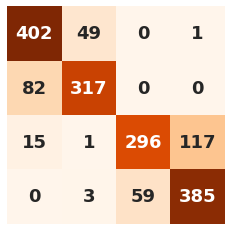

<Figure size 432x288 with 0 Axes>

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# # Define the confusion matrix array
confusion_matrix = np.array( [[402,  49,   0,   1],
                              [ 82, 317,   0,   0],
                              [ 15,   1, 296, 117],
                              [  0,   3,  59, 385]])
# Create a figure and axes
fig, ax = plt.subplots()
# Define the font size for the annotations
annot_font_family = 'Times New Roman'
annot_font_weight = 'bold'
annot_font_size = 18
# Plot the confusion matrix with custom font size for the annotations
sns.heatmap(confusion_matrix, annot=True, fmt='d',
            cmap='Oranges', cbar=False, square=True,
            xticklabels=False, yticklabels=False,
            annot_kws={'fontsize': annot_font_size,
                      #  'fontfamily': annot_font_family,
                       'fontweight': annot_font_weight}, ax=ax)
# Remove x-label, y-label, x-tick labels, and y-tick labels
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_xticklabels([])
ax.set_yticklabels([])
# Show the plot
plt.show()
plt.savefig('cm.png', dpi=300)

In [ ]:
test_loss, test_accuracy, test_auc, test_precision, test_recall = model.evaluate(XX_set, YY_set)
print("test_loss: ", test_loss)
print("test_accuracy: ", test_accuracy)
print("test_auc: ", test_auc)
print("test_precision: ", test_precision)
print("test_recall: ", test_recall)

#### Save model results

In [ ]:
eval_dict = {"y_test_true":y_test_true, "y_test_pred":y_test_pred, "test_loss":test_loss, "test_accuracy":test_accuracy, "test_auc":test_auc, "test_precision":test_precision, "test_recall":test_recall}
model.save(os.path.join(HOST_path, "IDB_drilling_signal/outputs/C_model.hdf5"))
np.save(os.path.join(HOST_path, "IDB_drilling_signal/outputs/C_history.npy"), history.history)
np.save(os.path.join(HOST_path, "IDB_drilling_signal/outputs/C_evaluation.npy"), eval_dict)

#### Load model results

In [ ]:
# model = load_model(os.path.join(HOST_path, "IDB_drilling_signal/outputs/C_model.hdf5"))
# hist = np.load(os.path.join(HOST_path, "IDB_drilling_signal/outputs/C_history.npy"), allow_pickle=True).item()
# eval_dict = np.load(os.path.join(HOST_path, "IDB_drilling_signal/outputs/C_evaluation.npy"), allow_pickle=True).item()

#### Plot model results

In [ ]:
def plot_history_metrics(history):
  total_plots = len(history)
  cols = total_plots // 2
  rows = total_plots // cols
  if total_plots % cols != 0:
    rows += 1
  pos = range(1, total_plots + 1)
  plt.figure(figsize=(15, 10))
  for i, (key, value) in enumerate(history.items()):
    plt.subplot(rows, cols, pos[i])
    plt.plot(range(len(value)), value)
    plt.title(str(key))
  plt.savefig(os.path.join(HOST_path, "IDB_drilling_signal/outputs/C_evaluation.png"))

plot_history_metrics(history.history)

## Regression

### Data pre-treatment

In [ ]:
# X_set = np.concatenate((S11,S12,S13,S14,S21,S22,S23,S31,S32,S33,S41,S42,S43,S51,S52,S53,S54,S61,S62,S63,S71,S72,S73,S74,S81,S82,S83,S91,S92,S93,S94), axis=0)
# X_set = X_set.reshape((X_set.shape[0], X_set.shape[1], 1))
# S1Y = [0,0,0, 150, 200, 8]
# S2Y = [0,0,0, 250, 250, 10]
# S3Y = [0,0,0, 350, 150, 6]
# S4Y = [0,1,0, 150, 250, 6]
# S5Y = [0,1,0, 250, 150, 8]
# S6Y = [0,1,0, 350, 200, 10]
# S7Y = [0,0,1, 150, 150, 10]
# S8Y = [0,0,1, 250, 200, 6]
# S9Y = [0,0,1, 350, 250, 8]
# S1L = len(S11)+len(S12)+len(S13)+len(S14)
# S2L = len(S21)+len(S22)+len(S23)
# S3L = len(S31)+len(S32)+len(S33)
# S4L = len(S41)+len(S42)+len(S43)
# S5L = len(S51)+len(S52)+len(S53)+len(S54)
# S6L = len(S61)+len(S62)+len(S63)
# S7L = len(S71)+len(S72)+len(S73)+len(S74)
# S8L = len(S81)+len(S82)+len(S83)
# S9L = len(S91)+len(S92)+len(S93)+len(S94)
# S_1 = [S1Y for _ in range(S1L)]
# S_2 = [S2Y for _ in range(S2L)]
# S_3 = [S3Y for _ in range(S3L)]
# S_4 = [S4Y for _ in range(S4L)]
# S_5 = [S5Y for _ in range(S5L)]
# S_6 = [S6Y for _ in range(S6L)]
# S_7 = [S7Y for _ in range(S7L)]
# S_8 = [S8Y for _ in range(S8L)]
# S_9 = [S9Y for _ in range(S9L)]
# Y_set = np.concatenate((S_1,S_2,S_3,S_4,S_5,S_6,S_7,S_8,S_9), axis=0)
# num_targets = Y_set.shape[1]
# x_train, x_test, y_train, y_test = train_test_split(X_set, Y_set, test_size=0.25, random_state=42)

### Model establishment

In [ ]:
# from keras.models import Sequential
# from keras.layers import Conv1D, MaxPooling1D, BatchNormalization
# from keras.layers import Activation, Dropout, Flatten, Dense

# def make_cnn_model():
#     model = Sequential()
#     model.add(Conv1D(64, 3, input_shape=x_train.shape[1:], padding='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(Conv1D(64, 3, padding='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=2, strides=2))
#     model.add(Conv1D(128, 3, padding='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(Conv1D(128, 3, padding='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=2, strides=2))
#     model.add(Conv1D(256, 3, padding='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(Conv1D(256, 3, padding='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(Conv1D(256, 3, padding='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=2, strides=2))
#     model.add(Conv1D(512, 3, padding='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(Conv1D(512, 3, padding='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(Conv1D(512, 3, padding='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=2, strides=2))
#     model.add(Conv1D(512, 3, padding='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(Conv1D(512, 3, padding='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(Conv1D(512, 3, padding='same'))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=2, strides=2))
#     model.add(Flatten())
#     model.add(Dense(256))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(Dropout(0.2))
#     model.add(Dense(4096))
#     model.add(BatchNormalization())
#     model.add(Activation('relu'))
#     model.add(Dropout(0.2))
#     model.add(Dense(num_targets, activation='linear'))
#     return model

# model = make_cnn_model()
# model.summary()
# # keras.utils.plot_model(model, show_shapes=True)

### Complete & Train

In [ ]:
# model.compile(optimizer='adam', loss='mse')

# callbacks = [
#             #  keras.callbacks.ModelCheckpoint("best_model.hdf5",
#             #                                  monitor="loss",
#             #                                  mode="min",
#             #                                  save_best_only=True),
#              keras.callbacks.EarlyStopping(monitor="val_loss",
#                                            mode="min",
#                                            verbose=1,
#                                            patience=10,
#                                            restore_best_weights=True),
#              keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
#                                                factor=0.2,
#                                                patience=2,
#                                                min_lr=0.000001),
#             # keras.callbacks.TensorBoard(log_dir=os.path.join(HOST_path, "IDB_drilling_signal/outputs/R_logs"),
#             #                             histogram_freq=1,
#             #                             write_graph=True,
#             #                             write_images=True),
#             ]

# history = model.fit(x_train, y_train,
#                     validation_split=0.2,
#                     epochs=200,
#                     batch_size=32,
#                     # callbacks=callbacks,
#                     shuffle=True)

### Show model results

In [ ]:
# y_test_true = y_test
# y_test_pred = model.predict(x_test)
# test_loss = model.evaluate(x_test, y_test)

### Save model results

In [ ]:
# eval_dict = {"y_test_true":y_test_true, "y_test_pred":y_test_pred, "test_loss":test_loss}

# model.save(os.path.join(HOST_path, "IDB_drilling_signal/outputs/R_model.hdf5"))
# np.save(os.path.join(HOST_path, "IDB_drilling_signal/outputs/R_history.npy"), history.history)
# np.save(os.path.join(HOST_path, "IDB_drilling_signal/outputs/R_evaluation.npy"), eval_dict)

### Load model results

In [ ]:
# from keras.models import load_model

# model = load_model("/home/svu/e1097232/IDB_drilling_signal/outputs/R_model.hdf5")
# hist = np.load("/home/svu/e1097232/IDB_drilling_signal/outputs/R_history.npy", allow_pickle=True)
# eval_dict = np.load("/home/svu/e1097232/IDB_drilling_signal/outputs/R_evaluation.npy", allow_pickle=True)

### Plot model results

In [ ]:
# # Plot Loss-Epoch
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model Loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train set', 'Test set'], loc='upper left')
# plt.savefig(os.path.join(HOST_path, "IDB_drilling_signal/outputs/R_loss.png"))
# plt.show()